<a href="https://colab.research.google.com/github/sriramxdev/Cats-and-Dogs_Project/blob/main/cats_and_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification of Cats and Dogs using CNN


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop
from sklearn.metrics import confusion_matrix, classification_report
import urllib.request
import zipfile
import time

# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("TensorFlow version:", tf.__version__)


Num GPUs Available:  1
TensorFlow version: 2.18.0


### Download and Prepare the Dataset

In [ ]:
# Function to download and extract the dataset
def download_and_extract_dataset():
    # Create directories for the dataset
    base_dir = 'dataset'
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)

    # URL for the dataset (Microsoft Cats and Dogs dataset)
    url = 'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip'

    # Path to save the downloaded zip file
    zip_path = os.path.join(base_dir, 'cats_and_dogs.zip')

    # Download the dataset if it doesn't exist
    if not os.path.exists(zip_path):
        print("Downloading dataset...")
        urllib.request.urlretrieve(url, zip_path)
        print("Download complete!")

    # Extract the dataset if not already extracted
    extract_dir = os.path.join(base_dir, 'PetImages')
    if not os.path.exists(extract_dir):
        print("Extracting dataset...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(base_dir)
        print("Extraction complete!")

    return base_dir

# Download and extract the dataset
base_dir = download_and_extract_dataset()


Download complete!
Extracting dataset...
Extraction complete!


In [ ]:
# Organize the dataset into train, validation, and test sets
def organize_dataset(base_dir):
    # Create directories for train, validation, and test sets
    train_dir = os.path.join(base_dir, 'train')
    val_dir = os.path.join(base_dir, 'validation')
    test_dir = os.path.join(base_dir, 'test')

    # Create subdirectories for cats and dogs in each set
    for dir_path in [train_dir, val_dir, test_dir]:
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
            os.makedirs(os.path.join(dir_path, 'cats'))
            os.makedirs(os.path.join(dir_path, 'dogs'))

    # If the dataset is already organized, return the directories
    if len(os.listdir(os.path.join(train_dir, 'cats'))) > 0:
        print("Dataset already organized.")
        return train_dir, val_dir, test_dir

    # Source directories for cats and dogs
    cats_dir = os.path.join(base_dir, 'PetImages', 'Cat')
    dogs_dir = os.path.join(base_dir, 'PetImages', 'Dog')

    # Function to remove corrupted images
    def is_valid_image(file_path):
        try:
            img = cv2.imread(file_path)
            return img is not None
        except:
            return False

    # Get list of valid cat and dog images
    cat_files = [f for f in os.listdir(cats_dir) if is_valid_image(os.path.join(cats_dir, f))]
    dog_files = [f for f in os.listdir(dogs_dir) if is_valid_image(os.path.join(dogs_dir, f))]

    # Shuffle the files
    random.shuffle(cat_files)
    random.shuffle(dog_files)

    # Split the files into train (70%), validation (15%), and test (15%) sets
    n_cats_train = int(0.7 * len(cat_files))
    n_cats_val = int(0.15 * len(cat_files))

    n_dogs_train = int(0.7 * len(dog_files))
    n_dogs_val = int(0.15 * len(dog_files))

    # Copy cat images to their respective directories
    for i, file in enumerate(cat_files):
        src = os.path.join(cats_dir, file)
        if i < n_cats_train:
            dst = os.path.join(train_dir, 'cats', file)
        elif i < n_cats_train + n_cats_val:
            dst = os.path.join(val_dir, 'cats', file)
        else:
            dst = os.path.join(test_dir, 'cats', file)
        os.link(src, dst)  # Create hard link instead of copying to save space

    # Copy dog images to their respective directories
    for i, file in enumerate(dog_files):
        src = os.path.join(dogs_dir, file)
        if i < n_dogs_train:
            dst = os.path.join(train_dir, 'dogs', file)
        elif i < n_dogs_train + n_dogs_val:
            dst = os.path.join(val_dir, 'dogs', file)
        else:
            dst = os.path.join(test_dir, 'dogs', file)
        os.link(src, dst)  # Create hard link instead of copying to save space

    print(f"Dataset organized into:\n"
          f"- Train: {len(os.listdir(os.path.join(train_dir, 'cats')))} cats, {len(os.listdir(os.path.join(train_dir, 'dogs')))} dogs\n"
          f"- Validation: {len(os.listdir(os.path.join(val_dir, 'cats')))} cats, {len(os.listdir(os.path.join(val_dir, 'dogs')))} dogs\n"
          f"- Test: {len(os.listdir(os.path.join(test_dir, 'cats')))} cats, {len(os.listdir(os.path.join(test_dir, 'dogs')))} dogs")

    return train_dir, val_dir, test_dir

# Organize the dataset
train_dir, val_dir, test_dir = organize_dataset(base_dir)


Dataset organized into:
- Train: 8748 cats, 8749 dogs
- Validation: 1874 cats, 1874 dogs
- Test: 1876 cats, 1876 dogs


### Data Visualization


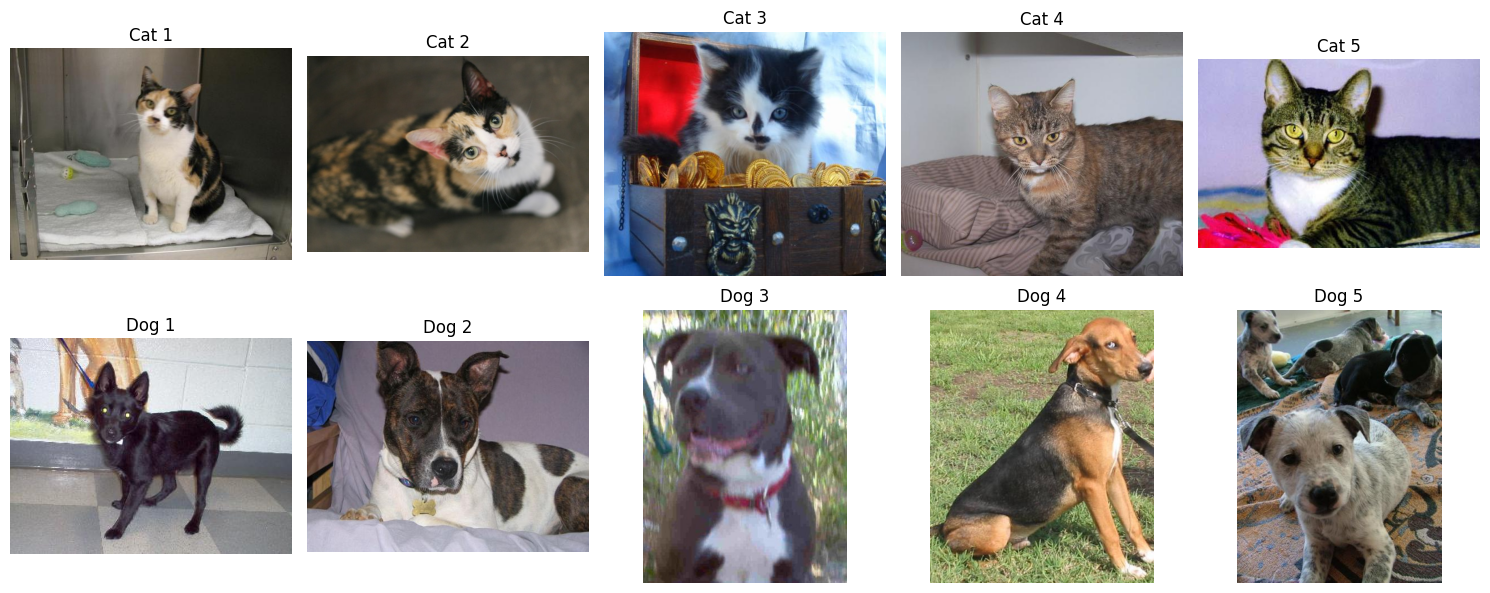

In [ ]:
# Function to display random images from the dataset
def display_random_images(directory, n=5):
    cats_dir = os.path.join(directory, 'cats')
    dogs_dir = os.path.join(directory, 'dogs')

    cat_files = random.sample(os.listdir(cats_dir), n)
    dog_files = random.sample(os.listdir(dogs_dir), n)

    plt.figure(figsize=(15, 6))

    # Display cat images
    for i, file in enumerate(cat_files):
        img_path = os.path.join(cats_dir, file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

        plt.subplot(2, n, i+1)
        plt.imshow(img)
        plt.title(f'Cat {i+1}')
        plt.axis('off')

    # Display dog images
    for i, file in enumerate(dog_files):
        img_path = os.path.join(dogs_dir, file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

        plt.subplot(2, n, n+i+1)
        plt.imshow(img)
        plt.title(f'Dog {i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display random images from the training set
display_random_images(train_dir)


### 4. Data Preprocessing and Augmentation

In [ ]:
# Define image dimensions and batch size
IMG_WIDTH = 150
IMG_HEIGHT = 150
BATCH_SIZE = 32

# Create data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create data generators without augmentation for validation and test
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators for training, validation, and test sets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Found 17497 images belonging to 2 classes.
Found 3748 images belonging to 2 classes.
Found 3752 images belonging to 2 classes.


### Visualization

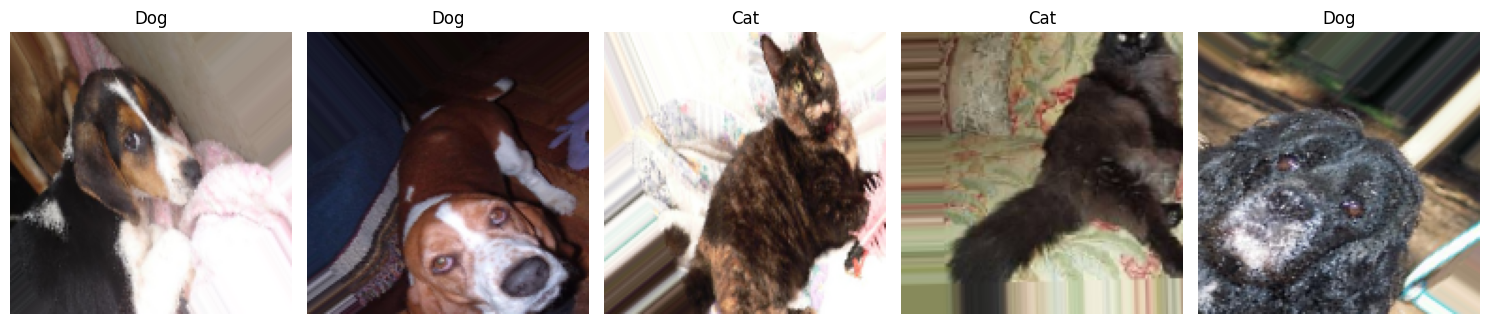

In [ ]:
# Function to display augmented images
def display_augmented_images():
    # Get a batch of images from the training generator
    x_batch, y_batch = next(train_generator)

    # Display 5 augmented images
    plt.figure(figsize=(15, 6))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(x_batch[i])
        plt.title('Cat' if y_batch[i] == 0 else 'Dog')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display augmented images
display_augmented_images()


### Build the CNN Model


In [ ]:
# Function to create the CNN model
def create_model():
    model = Sequential([
        # First convolutional block
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        MaxPooling2D(2, 2),
        BatchNormalization(),

        # Second convolutional block
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        BatchNormalization(),

        # Third convolutional block
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        BatchNormalization(),

        # Fourth convolutional block
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        BatchNormalization(),

        # Flatten the output and add dense layers
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),  # Add dropout to prevent overfitting
        Dense(1, activation='sigmoid')  # Binary classification (cat or dog)
    ])

    # Compile the model
    model.compile(
        optimizer=RMSprop(learning_rate=0.0005),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create the model
model = create_model()

# Display the model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 74, 74, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 36, 36, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 17, 17, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,454,529 (13.18 MB)

 Trainable params: 3,453,825 (13.18 MB)

 Non-trainable params: 704 (2.75 KB)

### Train the Model

In [ ]:
# Create callbacks for training
callbacks = [
    # Stop training when validation loss stops improving
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),

    # Save the best model during training
    ModelCheckpoint('models/cats_dogs_model.h5', monitor='val_accuracy', save_best_only=True, mode='max'),

    # Reduce learning rate when validation loss plateaus
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
]

# Calculate steps per epoch and validation steps
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = validation_generator.samples // BATCH_SIZE

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.5936 - loss: 1.4002

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


546/546 ━━━━━━━━━━━━━━━━━━━━ 134s 232ms/step - accuracy: 0.5937 - loss: 1.3997 - val_accuracy: 0.6677 - val_loss: 0.6379 - learning_rate: 5.0000e-04
Epoch 2/50
  1/546 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.6562 - loss: 0.6664

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


546/546 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.6562 - loss: 0.6664 - val_accuracy: 0.6741 - val_loss: 0.6195 - learning_rate: 5.0000e-04
Epoch 3/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.6773 - loss: 0.6389

546/546 ━━━━━━━━━━━━━━━━━━━━ 122s 223ms/step - accuracy: 0.6773 - loss: 0.6388 - val_accuracy: 0.7431 - val_loss: 0.6609 - learning_rate: 5.0000e-04
Epoch 4/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.7188 - loss: 0.5852 - val_accuracy: 0.7404 - val_loss: 0.6669 - learning_rate: 5.0000e-04
Epoch 5/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.7423 - loss: 0.5358

546/546 ━━━━━━━━━━━━━━━━━━━━ 133s 219ms/step - accuracy: 0.7423 - loss: 0.5357 - val_accuracy: 0.8251 - val_loss: 0.4018 - learning_rate: 5.0000e-04
Epoch 6/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7500 - loss: 0.4841 - val_accuracy: 0.8235 - val_loss: 0.4169 - learning_rate: 5.0000e-04
Epoch 7/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 142s 261ms/step - accuracy: 0.7655 - loss: 0.4879 - val_accuracy: 0.7094 - val_loss: 1.2730 - learning_rate: 5.0000e-04
Epoch 8/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7812 - loss: 0.7659 - val_accuracy: 0.7228 - val_loss: 0.7222 - learning_rate: 5.0000e-04
Epoch 9/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.8029 - loss: 0.4280

546/546 ━━━━━━━━━━━━━━━━━━━━ 202s 271ms/step - accuracy: 0.8029 - loss: 0.4280 - val_accuracy: 0.8526 - val_loss: 0.3532 - learning_rate: 1.0000e-04
Epoch 10/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8750 - loss: 0.3215 - val_accuracy: 0.8475 - val_loss: 0.3607 - learning_rate: 1.0000e-04
Epoch 11/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.8259 - loss: 0.3840

546/546 ━━━━━━━━━━━━━━━━━━━━ 117s 214ms/step - accuracy: 0.8259 - loss: 0.3840 - val_accuracy: 0.8600 - val_loss: 0.3239 - learning_rate: 1.0000e-04
Epoch 12/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7500 - loss: 0.4701 - val_accuracy: 0.8582 - val_loss: 0.3280 - learning_rate: 1.0000e-04
Epoch 13/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.8386 - loss: 0.3663

546/546 ━━━━━━━━━━━━━━━━━━━━ 142s 260ms/step - accuracy: 0.8386 - loss: 0.3663 - val_accuracy: 0.8771 - val_loss: 0.3013 - learning_rate: 1.0000e-04
Epoch 14/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.7812 - loss: 0.5207 - val_accuracy: 0.8739 - val_loss: 0.2973 - learning_rate: 1.0000e-04
Epoch 15/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 201s 271ms/step - accuracy: 0.8442 - loss: 0.3570 - val_accuracy: 0.8753 - val_loss: 0.3156 - learning_rate: 1.0000e-04
Epoch 16/50
  1/546 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - accuracy: 0.9062 - loss: 0.2644

546/546 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9062 - loss: 0.2644 - val_accuracy: 0.8779 - val_loss: 0.3028 - learning_rate: 1.0000e-04
Epoch 17/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.8475 - loss: 0.3426

546/546 ━━━━━━━━━━━━━━━━━━━━ 142s 260ms/step - accuracy: 0.8475 - loss: 0.3426 - val_accuracy: 0.8801 - val_loss: 0.2880 - learning_rate: 1.0000e-04
Epoch 18/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7812 - loss: 0.4008 - val_accuracy: 0.8755 - val_loss: 0.2992 - learning_rate: 1.0000e-04
Epoch 19/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 202s 271ms/step - accuracy: 0.8498 - loss: 0.3439 - val_accuracy: 0.8483 - val_loss: 0.4386 - learning_rate: 1.0000e-04
Epoch 20/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9062 - loss: 0.2256 - val_accuracy: 0.8408 - val_loss: 0.4791 - learning_rate: 1.0000e-04
Epoch 21/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.8632 - loss: 0.3197

546/546 ━━━━━━━━━━━━━━━━━━━━ 118s 217ms/step - accuracy: 0.8632 - loss: 0.3197 - val_accuracy: 0.8977 - val_loss: 0.2629 - learning_rate: 2.0000e-05
Epoch 22/50
  1/546 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - accuracy: 0.8750 - loss: 0.2219

546/546 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8750 - loss: 0.2219 - val_accuracy: 0.8982 - val_loss: 0.2621 - learning_rate: 2.0000e-05
Epoch 23/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 142s 227ms/step - accuracy: 0.8720 - loss: 0.3018 - val_accuracy: 0.8841 - val_loss: 0.3023 - learning_rate: 2.0000e-05
Epoch 24/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8750 - loss: 0.2053 - val_accuracy: 0.8841 - val_loss: 0.3030 - learning_rate: 2.0000e-05
Epoch 25/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.8663 - loss: 0.3084

546/546 ━━━━━━━━━━━━━━━━━━━━ 128s 213ms/step - accuracy: 0.8663 - loss: 0.3084 - val_accuracy: 0.9014 - val_loss: 0.2571 - learning_rate: 2.0000e-05
Epoch 26/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9375 - loss: 0.2715 - val_accuracy: 0.8998 - val_loss: 0.2579 - learning_rate: 2.0000e-05
Epoch 27/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 142s 224ms/step - accuracy: 0.8708 - loss: 0.3079 - val_accuracy: 0.9006 - val_loss: 0.2512 - learning_rate: 2.0000e-05
Epoch 28/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8750 - loss: 0.4859 - val_accuracy: 0.9001 - val_loss: 0.2542 - learning_rate: 2.0000e-05
Epoch 29/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 142s 235ms/step - accuracy: 0.8678 - loss: 0.3041 - val_accuracy: 0.8913 - val_loss: 0.2784 - learning_rate: 2.0000e-05
Epoch 30/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9062 - loss: 0.2087 - val_accuracy: 0.8910 - val_loss: 0.2830 - learning_rate: 2.0000e-05
Epoch 31/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 118s 215ms/ste

### Model Evaluation

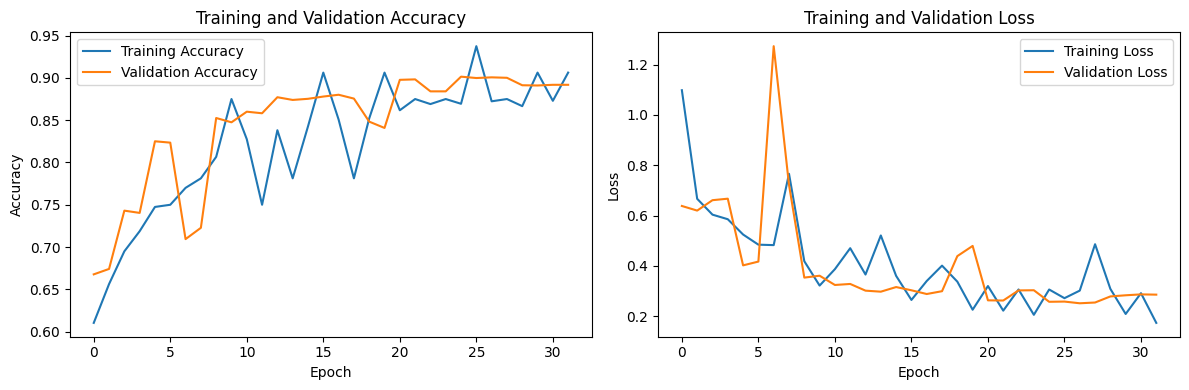

In [ ]:
# Plot training and validation accuracy and loss
def plot_training_history(history):
    # Plot accuracy
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)


In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.8917 - loss: 0.2796
Test Accuracy: 0.8998
Test Loss: 0.2442


118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step


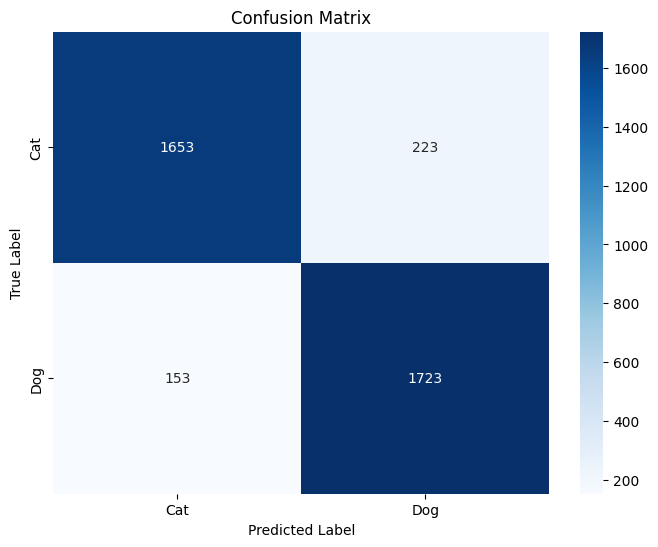

Classification Report:
              precision    recall  f1-score   support

         Cat       0.92      0.88      0.90      1876
         Dog       0.89      0.92      0.90      1876

    accuracy                           0.90      3752
   macro avg       0.90      0.90      0.90      3752
weighted avg       0.90      0.90      0.90      3752



In [ ]:
# Generate predictions for the test set
test_generator.reset()
predictions = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE + 1)
predicted_classes = (predictions > 0.5).astype(int).flatten()

# Get the true labels
true_classes = test_generator.classes

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=['Cat', 'Dog']))


### Visualize Model Predictions


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


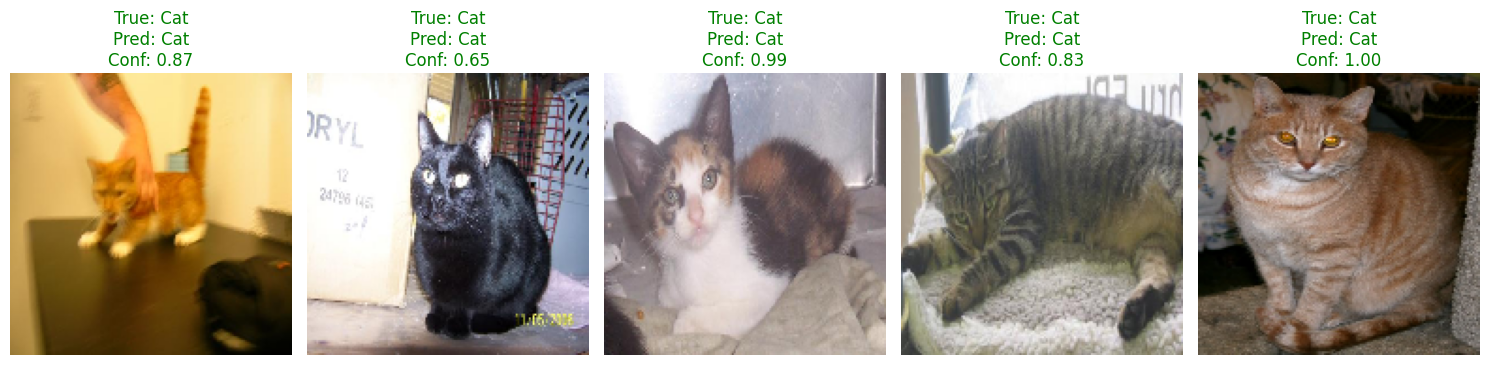

In [ ]:
# Function to display random test images with predictions
def display_predictions(n=5):
    # Reset the test generator
    test_generator.reset()

    # Get a batch of test images
    x_batch, y_batch = next(test_generator)

    # Make predictions on the batch
    predictions = model.predict(x_batch)

    # Display images with predictions
    plt.figure(figsize=(15, 6))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(x_batch[i])

        # Get the true and predicted labels
        true_label = 'Cat' if y_batch[i] == 0 else 'Dog'
        pred_label = 'Cat' if predictions[i][0] < 0.5 else 'Dog'
        confidence = predictions[i][0] if pred_label == 'Dog' else 1 - predictions[i][0]

        # Set the title color based on whether the prediction is correct
        color = 'green' if true_label == pred_label else 'red'

        plt.title(f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}", color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display predictions on random test images
display_predictions()


### Save the Model


In [ ]:
# Create the models directory if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')

# Save the model in HDF5 format
model.save('models/cats_dogs_model.h5')
print("Model saved in HDF5 format.")

# Save the model in SavedModel format (TensorFlow's recommended format)
model.save('models/cats_dogs_savedmodel.keras')
print("Model saved in SavedModel format.")


Model saved in HDF5 format.
Model saved in SavedModel format.


### Test the Saved Model


In [ ]:
# Load the saved model
loaded_model = load_model('models/cats_dogs_model.h5')

# Evaluate the loaded model on the test set
test_generator.reset()
test_loss, test_accuracy = loaded_model.evaluate(test_generator)
print(f"Loaded Model Test Accuracy: {test_accuracy:.4f}")
print(f"Loaded Model Test Loss: {test_loss:.4f}")


118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.8917 - loss: 0.2796
Loaded Model Test Accuracy: 0.8998
Loaded Model Test Loss: 0.2442
